In [2]:
DEBUG = False
TRAIN = True

MAX_SEQ_LENGTH = 128

FEATURE_NAMES = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z',
    'acc_mag', 'rot_angle', 'acc_mag_jerk', 'rot_angle_vel',
    'linear_acc_x', 'linear_acc_y', 'linear_acc_z', 'linear_acc_mag', 'linear_acc_mag_jerk',
    'angular_vel_x', 'angular_vel_y', 'angular_vel_z',
    'angular_distance',
]
CATEGORICAL_FEATURES = []
NUMERICAL_FEATURES = [f for f in FEATURE_NAMES if f not in CATEGORICAL_FEATURES]

LABEL_NAMES = [
    'Forehead - pull hairline',
    'Neck - pinch skin',
    'Forehead - scratch',
    'Eyelash - pull hair',
    'Text on phone',
    'Eyebrow - pull hair',
    'Neck - scratch',
    'Above ear - pull hair',
    'Cheek - pinch skin',
    'Wave hello',
    'Write name in air',
    'Pull air toward your face',
    'Feel around in tray and pull out an object',
    'Write name on leg',
    'Pinch knee/leg skin',
    'Scratch knee/leg skin',
    'Drink from bottle/cup',
    'Glasses on/off'
]
IDX2LABEL = {x: i for i, x in enumerate(LABEL_NAMES)}

OUTPUT_DIR = './saved_models'

In [3]:
import os
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

In [6]:
DATA_ROOT = '/kaggle/input/cmi-detection'

train_df = pd.read_csv(f'{DATA_ROOT}/train.csv')
train_demo_df = pd.read_csv(f'{DATA_ROOT}/train_demographics.csv')

In [7]:
train_df = pd.merge(
    train_df,
    train_demo_df,
    how='left',
    on='subject'
)
print(train_df.shape[0])

574945


In [9]:
# Remove Gravity
from scipy.spatial.transform import Rotation as R

def remove_gravity_from_acc(acc_data, rot_data):
    if isinstance(acc_data, pd.DataFrame):
        acc_values = acc_data[['acc_x', 'acc_y', 'acc_z']].values
    else:
        acc_values = acc_data

    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)
    gravity_world = np.array([0, 0, 9.81])

    for i in range(num_samples):
        if np.all(np.isnan(quat_values[i])) or np.all(np.isclose(quat_values[i], 0)):
            linear_accel[i, :] = acc_values[i, :] 
            continue

        try:
            rotation = R.from_quat(quat_values[i])
            gravity_sensor_frame = rotation.apply(gravity_world, inverse=True)
            linear_accel[i, :] = acc_values[i, :] - gravity_sensor_frame
        except ValueError:
            linear_accel[i, :] = acc_values[i, :]
             
    return linear_accel

def calculate_angular_velocity_from_quat(rot_data, time_delta=1/200):
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_vel = np.zeros((num_samples, 3))

    for i in range(num_samples - 1):
        q_t = quat_values[i]
        q_t_plus_dt = quat_values[i+1]

        if np.all(np.isnan(q_t)) or np.all(np.isclose(q_t, 0)) or \
           np.all(np.isnan(q_t_plus_dt)) or np.all(np.isclose(q_t_plus_dt, 0)):
            continue

        try:
            rot_t = R.from_quat(q_t)
            rot_t_plus_dt = R.from_quat(q_t_plus_dt)
            delta_rot = rot_t.inv() * rot_t_plus_dt
            angular_vel[i, :] = delta_rot.as_rotvec() / time_delta
        except ValueError:
            pass
            
    return angular_vel

def calculate_angular_distance(rot_data):
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_dist = np.zeros(num_samples)

    for i in range(num_samples - 1):
        q1 = quat_values[i]
        q2 = quat_values[i+1]

        if np.all(np.isnan(q1)) or np.all(np.isclose(q1, 0)) or \
           np.all(np.isnan(q2)) or np.all(np.isclose(q2, 0)):
            angular_dist[i] = 0
            continue
        try:
            r1 = R.from_quat(q1)
            r2 = R.from_quat(q2)
            relative_rotation = r1.inv() * r2
            angle = np.linalg.norm(relative_rotation.as_rotvec())
            angular_dist[i] = angle
        except ValueError:
            angular_dist[i] = 0
            pass
    return angular_dist

In [10]:
def feature_engineering(df):
    # IMU magnitude
    df['acc_mag'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    
    # IMU angle
    df['rot_angle'] = 2 * np.arccos(df['rot_w'].clip(-1, 1))
    
    # IMU jerk, angular velocity
    df['acc_mag_jerk'] = df.groupby('sequence_id')['acc_mag'].diff().fillna(0)
    df['rot_angle_vel'] = df.groupby('sequence_id')['rot_angle'].diff().fillna(0)
    
    # Remove gravity
    def get_linear_accel(df):
        res = remove_gravity_from_acc(
            df[['acc_x', 'acc_y', 'acc_z']],
            df[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
        )
        res = pd.DataFrame(res, columns=['linear_acc_x', 'linear_acc_y', 'linear_acc_z'], index=df.index)
        return res
    
    linear_accel_df = df.groupby('sequence_id').apply(get_linear_accel, include_groups=False)
    linear_accel_df = linear_accel_df.droplevel('sequence_id')
    df = df.join(linear_accel_df)
    
    df['linear_acc_mag'] = np.sqrt(df['linear_acc_x']**2 + df['linear_acc_y']**2 + df['linear_acc_z']**2)
    df['linear_acc_mag_jerk'] = df.groupby('sequence_id')['linear_acc_mag'].diff().fillna(0)

    # Calc angular velocity
    def calc_angular_velocity(df):
        res = calculate_angular_velocity_from_quat( df[['rot_x', 'rot_y', 'rot_z', 'rot_w']] )
        res = pd.DataFrame(res, columns=['angular_vel_x', 'angular_vel_y', 'angular_vel_z'], index=df.index)
        return res
    
    angular_velocity_df = df.groupby('sequence_id').apply(calc_angular_velocity, include_groups=False)
    angular_velocity_df = angular_velocity_df.droplevel('sequence_id')
    df = df.join(angular_velocity_df)

    # Calculating angular distance
    def calc_angular_distance(df):
        res = calculate_angular_distance(df[['rot_x', 'rot_y', 'rot_z', 'rot_w']])
        res = pd.DataFrame(res, columns=['angular_distance'], index=df.index)
        return res
    
    angular_distance_df = df.groupby('sequence_id').apply(calc_angular_distance, include_groups=False)
    angular_distance_df = angular_distance_df.droplevel('sequence_id')
    df = df.join(angular_distance_df)

    df[FEATURE_NAMES] = df[FEATURE_NAMES].ffill().bfill().fillna(0).values.astype('float32')
    
    return df

In [11]:
train_df = feature_engineering(train_df)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
feature_scaler = StandardScaler()
feature_scaler.fit(train_df[NUMERICAL_FEATURES])
joblib.dump(feature_scaler, f'{OUTPUT_DIR}/feature_scaler.joblib')

['./saved_models/feature_scaler.joblib']

In [14]:
train_df[NUMERICAL_FEATURES] = feature_scaler.transform(train_df[NUMERICAL_FEATURES])

In [15]:
print(len(NUMERICAL_FEATURES))

20


In [16]:
agg_train_df = train_df.groupby(['sequence_id', 'subject', 'gesture']).apply(
    lambda df: df[FEATURE_NAMES].to_dict(orient='records'),
    include_groups=False,
).reset_index()
agg_train_df.columns = ['sequence_id', 'subject', 'gesture', 'sequence']

In [17]:
agg_train_df['label'] = agg_train_df.gesture.map(IDX2LABEL)

In [18]:
print(agg_train_df.head())

  sequence_id      subject                   gesture  \
0  SEQ_000007  SUBJ_059520        Cheek - pinch skin   
1  SEQ_000008  SUBJ_020948  Forehead - pull hairline   
2  SEQ_000013  SUBJ_040282        Cheek - pinch skin   
3  SEQ_000016  SUBJ_052342         Write name on leg   
4  SEQ_000018  SUBJ_032165  Forehead - pull hairline   

                                            sequence  label  
0  [{'acc_x': -0.13276900351047516, 'acc_y': -0.1...      8  
1  [{'acc_x': -0.24999308586120605, 'acc_y': -0.4...      0  
2  [{'acc_x': -0.5114390254020691, 'acc_y': -0.30...      8  
3  [{'acc_x': -0.1346389800310135, 'acc_y': -0.55...     13  
4  [{'acc_x': -0.20406180620193481, 'acc_y': -0.2...      0  


In [19]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        self.processed_sequences = self._process_sequences()
        
    def _process_sequences(self):
        processed = []
        for seq in self.sequences:
            seq = seq[:MAX_SEQ_LENGTH]
            seq_array = []
            for timestep in seq:
                features = [timestep[feature] for feature in FEATURE_NAMES]
                seq_array.append(features)
            processed.append(np.array(seq_array, dtype=np.float32))
        return processed
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.FloatTensor(self.processed_sequences[idx])
        label = torch.LongTensor([self.labels[idx]])[0]
        return sequence, label

def collate_fn(batch):
    sequences, labels = zip(*batch)
    max_length = max(seq.shape[0] for seq in sequences)
    
    padded_sequences = []
    lengths = []
    
    for seq in sequences:
        seq_len = seq.shape[0]
        lengths.append(seq_len)
        
        if seq_len < max_length:
            padding = torch.zeros(max_length - seq_len, seq.shape[1])
            padded_seq = torch.cat([seq, padding], dim=0)
        else:
            padded_seq = seq
        padded_sequences.append(padded_seq)
    
    return torch.stack(padded_sequences), torch.stack(labels), torch.LongTensor(lengths)

def create_kfold_splits(sequences, labels, subjects, n_splits=5, random_state=42):
    sequences = np.array(sequences, dtype=object)
    labels = np.array(labels)
    subjects = np.array(subjects)

    if sequences.shape[0] > 1000:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        n_splits = 2
        sgkf = GroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    splits = []
    for fold_idx, (train_idx, val_idx) in enumerate(sgkf.split(sequences, labels, subjects)):
        splits.append((train_idx, val_idx))
        print(f"   Fold {fold_idx+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    
    print(f"✅ Created {n_splits}-fold cross-validation splits")
    return splits

def create_fold_loaders(sequences, labels, train_idx, val_idx, batch_size=32):
    train_sequences = [sequences[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_sequences = [sequences[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]
    
    train_dataset = SequenceDataset(train_sequences, train_labels)
    val_dataset = SequenceDataset(val_sequences, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualSECNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool_size=2, dropout=0.3, weight_decay=1e-4):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm1d(out_channels)
            )  # Added missing closing parenthesis
        self.pool = nn.MaxPool1d(pool_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        shortcut = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += shortcut
        out = F.relu(out)
        out = self.pool(out)
        out = self.dropout(out)
        return out

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        scores = torch.tanh(self.attention(x))
        weights = F.softmax(scores.squeeze(-1), dim=1)
        context = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return context

class TwoBranchModel(nn.Module):
    def __init__(self, imu_dim, n_classes, weight_decay=1e-4):
        super().__init__()
        self.imu_dim = imu_dim
        self.n_classes = n_classes
        self.weight_decay = weight_decay
        
        # IMU deep branch
        self.imu_block1 = ResidualSECNNBlock(imu_dim, 64, 3, dropout=0.3, weight_decay=weight_decay)
        self.imu_block2 = ResidualSECNNBlock(64, 128, 5, dropout=0.3, weight_decay=weight_decay)
        
        # BiGRU
        self.bigru = nn.GRU(128, 128, bidirectional=True, batch_first=True)
        self.gru_dropout = nn.Dropout(0.4)
        
        # Attention
        self.attention = AttentionLayer(256)
        
        # Dense layers
        self.dense1 = nn.Linear(256, 256, bias=False)
        self.bn_dense1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.5)
        
        self.dense2 = nn.Linear(256, 128, bias=False)
        self.bn_dense2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)
        
        self.classifier = nn.Linear(128, n_classes)
        
    def forward(self, x):
        imu = x[:, :, :self.imu_dim]
        imu = imu.transpose(1, 2)
        
        # IMU branch
        x1 = self.imu_block1(imu)
        x1 = self.imu_block2(x1)
        
        merged = x1.transpose(1, 2)
        gru_out, _ = self.bigru(merged)
        gru_out = self.gru_dropout(gru_out)
        attended = self.attention(gru_out)
        
        x = F.relu(self.bn_dense1(self.dense1(attended)))
        x = self.drop1(x)
        x = F.relu(self.bn_dense2(self.dense2(x)))
        x = self.drop2(x)
        logits = self.classifier(x)
        return logits

In [23]:
import kagglehub
metric = kagglehub.package_import('jiazhuang/cmi-2025-metric')

def get_competition_score(true, pred):
    assert len(true) == len(pred)
    N = len(true)
    true_df = pd.DataFrame({'id': range(N), 'gesture': true})
    pred_df = pd.DataFrame({'id': range(N), 'gesture': pred})
    return metric.score(true_df, pred_df, 'id')

In [24]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json

class Trainer:
    def __init__(self, model, device, class_names):
        self.model = model.to(device)
        self.device = device
        self.class_names = class_names
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.val_scores = []
        
    def train_epoch(self, train_loader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for sequences, labels, lengths in train_loader:
            sequences = sequences.to(self.device)
            labels = labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = self.model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        return avg_loss, accuracy
    
    def validate(self, val_loader, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for sequences, labels, lengths in val_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        accuracy = correct / total
        return avg_loss, accuracy, all_preds, all_labels
    
    def train(self, train_loader, val_loader, num_epochs=50, lr=0.001, weight_decay=1e-5, patience=10, save_path='best_model.pth'):
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience//2)
        
        best_val_score = -float('inf')
        epochs_without_improvement = 0
        
        print(f"Training on device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, val_preds, val_true = self.validate(val_loader, criterion)
            val_preds_labels = [self.class_names[pred] for pred in val_preds]
            val_true_labels = [self.class_names[label] for label in val_true]
            val_score = get_competition_score(val_true_labels, val_preds_labels)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            self.val_scores.append(val_score)
            
            scheduler.step(val_score)
            
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                print("-" * 50)
                print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
                print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Score: {val_score:.4f}")
                print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
            
            if val_score > best_val_score:
                best_val_score = val_score
                epochs_without_improvement = 0
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'val_score': val_score,
                    'model_config': {
                        'imu_dim': self.model.imu_dim,
                        'n_classes': self.model.n_classes,
                        'weight_decay': self.model.weight_decay
                    }
                }, save_path)
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= patience:
                print(f"Early stopping: No improvement for {patience} epochs")
                break
        
        print("Training complete!")
        return self.train_losses, self.val_losses, self.train_accuracies, self.val_accuracies, self.val_scores
    
    def plot_training_history(self, save_path='training_history.png'):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.plot(self.train_losses, label='train loss')
        ax1.plot(self.val_losses, label='val loss')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(self.train_accuracies, label='train accuracy')
        ax2.plot(self.val_accuracies, label='val accuracy')
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)

        ax3.plot(self.val_scores, label='val score')
        ax3.set_title('Validation Score')
        ax3.set_xlabel('Epoch')
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Training history saved to {save_path}")

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_true = []
    all_probs = []
    
    with torch.no_grad():
        for sequences, labels, lengths in test_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = accuracy_score(all_true, all_preds)
    pred_labels = [class_names[pred] for pred in all_preds]
    true_labels = [class_names[label] for label in all_true]
    score = get_competition_score(true_labels, pred_labels)

    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Test score: {score:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_true, all_preds, target_names=class_names))
    
    return accuracy, score, all_preds, all_probs

In [27]:
def train_single_fold(sequences, labels, subjects, train_idx, val_idx, fold_num, total_folds, 
                     device, num_epochs=50, lr=0.001, patience=10, batch_size=16):
    print(f"\n{'='*60}")
    print(f"🔄 Training fold {fold_num}/{total_folds}")
    print(f"{'='*60}")
    
    train_loader, val_loader = create_fold_loaders(sequences, labels, train_idx, val_idx, batch_size)
    
    print(f"📊 Fold {fold_num} data:")
    print(f"   Train samples: {len(train_loader.dataset)}")
    print(f"   Val samples: {len(val_loader.dataset)}")
    print(f"   Train subjects: {len(set(subjects[i] for i in train_idx))}")
    print(f"   Val subjects: {len(set(subjects[i] for i in val_idx))}")
    
    num_classes = len(LABEL_NAMES)
    model = TwoBranchModel(imu_dim=len(FEATURE_NAMES), n_classes=num_classes, weight_decay=3e-3)
    print(f"✅ Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    trainer = Trainer(model, device, LABEL_NAMES)
    model_save_path = f'{OUTPUT_DIR}/fold_{fold_num}_model.pth'
    
    print(f"🏋️ Starting fold {fold_num} training...")
    trainer.train(train_loader, val_loader, num_epochs=num_epochs, lr=lr, 
                 patience=patience, save_path=model_save_path)
    
    print(f"✅ Fold {fold_num} training complete!")
    print(f"📈 Final train accuracy: {trainer.train_accuracies[-1]:.4f}")
    print(f"📊 Final val accuracy: {trainer.val_accuracies[-1]:.4f}")
    print(f"📊 Final val score: {trainer.val_scores[-1]:.4f}")

    history_plot_path = f'{OUTPUT_DIR}/fold_{fold_num}_training_history.png'
    trainer.plot_training_history(history_plot_path)
    
    checkpoint = torch.load(model_save_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    accuracy, score, _, _ = evaluate_model(model, val_loader, device, LABEL_NAMES)
    
    fold_results = {
        'fold': fold_num,
        'model_path': model_save_path,
        'final_train_acc': trainer.train_accuracies[-1],
        'final_val_acc': trainer.val_accuracies[-1],
        'final_val_score': trainer.val_scores[-1],
        'test_accuracy': accuracy,
        'test_score': score,
        'num_epochs': len(trainer.train_losses)
    }
    
    print(f"🎯 Fold {fold_num} results:")
    print(f"   Test accuracy: {accuracy:.4f}")
    print(f"   Test score: {score:.4f}")
    return fold_results

def run_kfold_training(train_df, n_folds=5, **kwargs):
    print("🚀 Starting K-fold cross-validation training")
    print("=" * 60)
    
    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    print(f"🧠 Using device: {device}")
    
    sequences = train_df['sequence'].tolist()
    labels = train_df['label'].tolist()
    subjects = train_df['subject'].tolist()
    
    num_classes = len(LABEL_NAMES)
    print(f"\n📋 Data info:")
    print(f"   Total samples: {len(sequences)}")
    print(f"   Classes: {num_classes}")
    print(f"   Subjects: {len(set(subjects))}")
    
    print(f"\n🏷️ Class examples:")
    for i, class_name in enumerate(LABEL_NAMES[:8]):
        print(f"   {i}: {class_name}")
    if len(LABEL_NAMES) > 8:
        print(f"   ... plus {len(LABEL_NAMES) - 8} more classes")
    
    print(f"\n📂 Creating {n_folds}-fold splits...")
    splits = create_kfold_splits(sequences, labels, subjects, n_splits=n_folds, random_state=42)
    
    fold_results = []
    for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
        fold_result = train_single_fold(
            sequences, labels, subjects, train_idx, val_idx,
            fold_num, n_folds, device, **kwargs
        )
        fold_results.append(fold_result)
    
    print(f"\n{'='*60}")
    print(f"🎉 {n_folds}-fold cross-validation complete!")
    print(f"{'='*60}")
    
    val_accs = [r['final_val_acc'] for r in fold_results]
    val_scores = [r['final_val_score'] for r in fold_results]
    test_accs = [r['test_accuracy'] for r in fold_results]
    test_scores = [r['test_score'] for r in fold_results]
    
    print(f"\n📊 K-fold results:")
    print(f"   Val accuracy: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
    print(f"   Val score: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
    print(f"   Test accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
    print(f"   Test score: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")
    
    print(f"\n📋 Fold details:")
    for i, result in enumerate(fold_results):
        print(f"   Fold {i+1}: Val Acc={result['final_val_acc']:.4f}, " +
              f"Val Score={result['final_val_score']:.4f}, " +
              f"Test Acc={result['test_accuracy']:.4f}, " +
              f"Test Score={result['test_score']:.4f}")
    
    kfold_results = {
        'n_folds': n_folds,
        'fold_results': fold_results,
        'summary': {
            'val_acc_mean': np.mean(val_accs),
            'val_acc_std': np.std(val_accs),
            'val_score_mean': np.mean(val_scores),
            'val_score_std': np.std(val_scores),
            'test_acc_mean': np.mean(test_accs),
            'test_acc_std': np.std(test_accs),
            'test_score_mean': np.mean(test_scores),
            'test_score_std': np.std(test_scores)
        },
    }
    
    with open(f'{OUTPUT_DIR}/kfold_results.json', 'w', encoding='utf-8') as f:
        json.dump(kfold_results, f, ensure_ascii=False, indent=2)

    print(f"💾 Results saved: kfold_results.json")
    return kfold_results

🚀 Starting K-fold cross-validation training
🧠 Using device: cuda

📋 Data info:
   Total samples: 8151
   Classes: 18
   Subjects: 81

🏷️ Class examples:
   0: Forehead - pull hairline
   1: Neck - pinch skin
   2: Forehead - scratch
   3: Eyelash - pull hair
   4: Text on phone
   5: Eyebrow - pull hair
   6: Neck - scratch
   7: Above ear - pull hair
   ... plus 10 more classes

📂 Creating 5-fold splits...
   Fold 1: Train=6623, Val=1528
   Fold 2: Train=6519, Val=1632
   Fold 3: Train=6526, Val=1625
   Fold 4: Train=6519, Val=1632
   Fold 5: Train=6417, Val=1734
✅ Created 5-fold cross-validation splits

🔄 Training fold 1/5
📊 Fold 1 data:
   Train samples: 6623
   Val samples: 1528
   Train subjects: 65
   Val subjects: 16
✅ Model parameters: 454,547
🏋️ Starting fold 1 training...
Training on device: cuda
Model parameters: 454,547

Epoch 1/100
--------------------------------------------------
Train - Loss: 2.3133, Acc: 0.2259
Val - Loss: 1.8284, Acc: 0.3488, Score: 0.5925
Current LR:

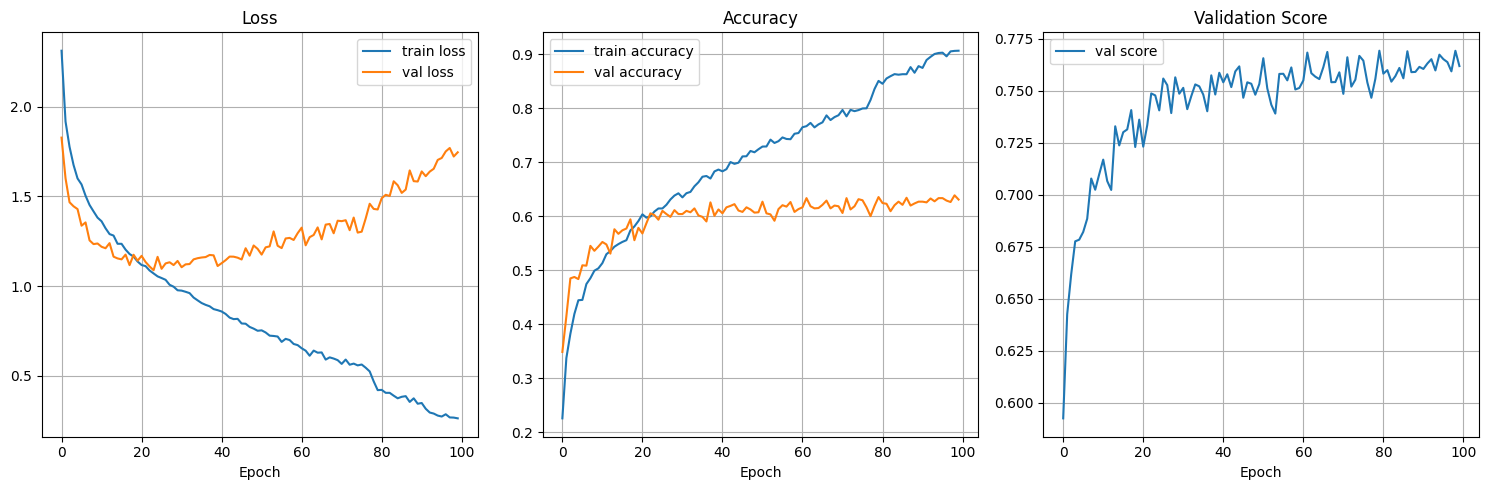

Training history saved to ./saved_models/fold_1_training_history.png
Test accuracy: 0.6355
Test score: 0.7693

Classification Report:
                                            precision    recall  f1-score   support

                  Forehead - pull hairline       0.51      0.66      0.57       120
                         Neck - pinch skin       0.43      0.50      0.46       120
                        Forehead - scratch       0.78      0.75      0.76       120
                       Eyelash - pull hair       0.52      0.46      0.49       120
                             Text on phone       0.83      0.92      0.87       120
                       Eyebrow - pull hair       0.36      0.39      0.38       120
                            Neck - scratch       0.63      0.42      0.50       120
                     Above ear - pull hair       0.52      0.51      0.51       120
                        Cheek - pinch skin       0.40      0.37      0.38       120
                         

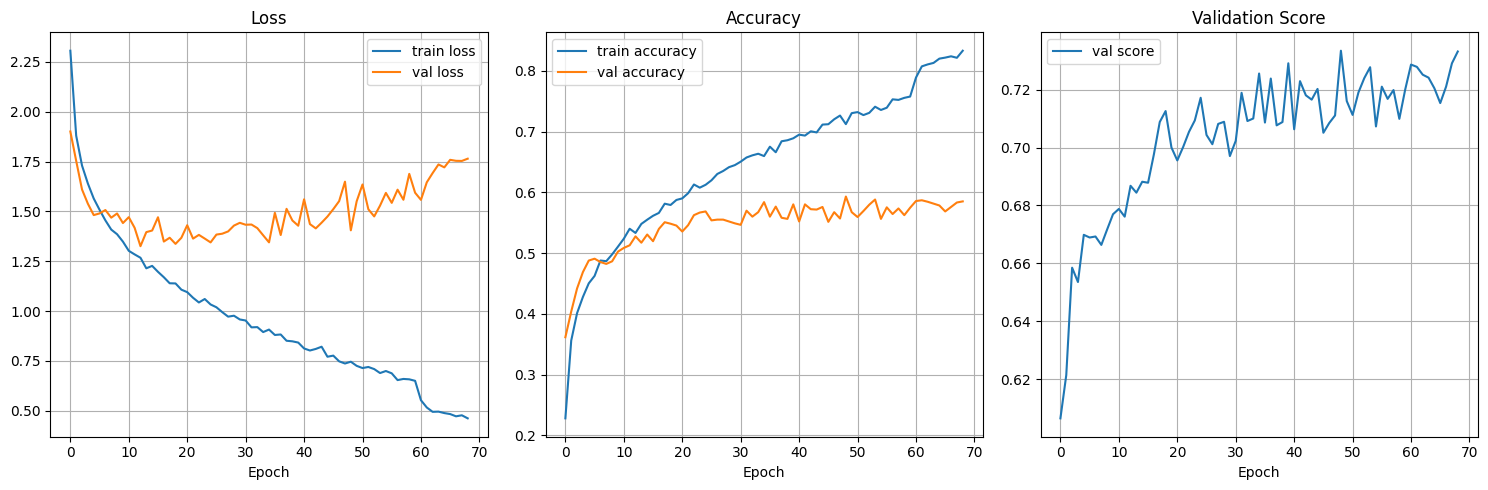

Training history saved to ./saved_models/fold_2_training_history.png
Test accuracy: 0.5931
Test score: 0.7335

Classification Report:
                                            precision    recall  f1-score   support

                  Forehead - pull hairline       0.51      0.56      0.54       128
                         Neck - pinch skin       0.34      0.31      0.33       128
                        Forehead - scratch       0.57      0.70      0.63       128
                       Eyelash - pull hair       0.57      0.48      0.53       128
                             Text on phone       0.90      0.84      0.87       128
                       Eyebrow - pull hair       0.35      0.30      0.33       128
                            Neck - scratch       0.41      0.35      0.38       128
                     Above ear - pull hair       0.48      0.50      0.49       128
                        Cheek - pinch skin       0.35      0.39      0.37       128
                         

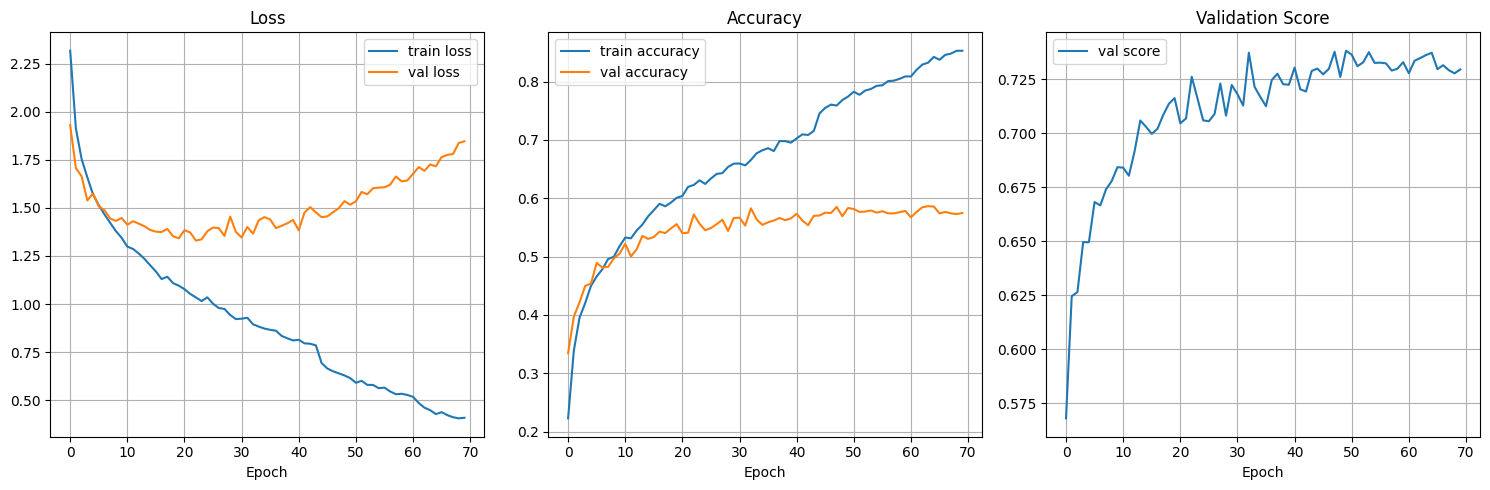

Training history saved to ./saved_models/fold_3_training_history.png
Test accuracy: 0.5834
Test score: 0.7381

Classification Report:
                                            precision    recall  f1-score   support

                  Forehead - pull hairline       0.53      0.38      0.45       128
                         Neck - pinch skin       0.36      0.42      0.39       128
                        Forehead - scratch       0.67      0.60      0.63       128
                       Eyelash - pull hair       0.47      0.61      0.53       128
                             Text on phone       0.83      0.93      0.88       128
                       Eyebrow - pull hair       0.30      0.31      0.30       126
                            Neck - scratch       0.46      0.43      0.45       128
                     Above ear - pull hair       0.52      0.44      0.48       126
                        Cheek - pinch skin       0.38      0.43      0.40       125
                         

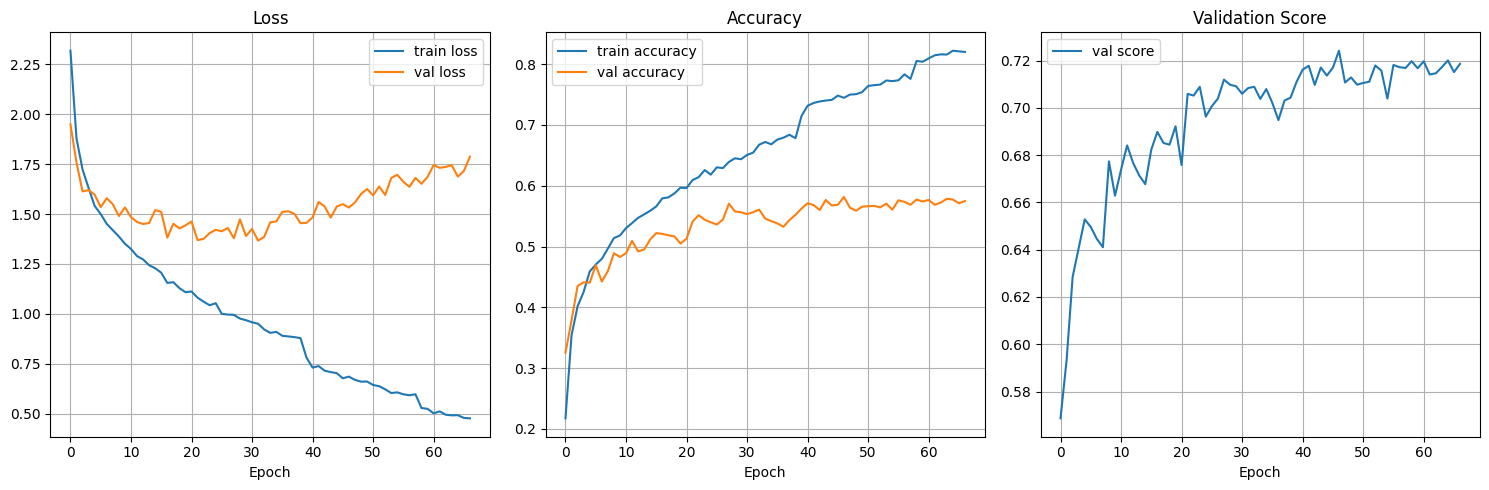

Training history saved to ./saved_models/fold_4_training_history.png
Test accuracy: 0.5815
Test score: 0.7242

Classification Report:
                                            precision    recall  f1-score   support

                  Forehead - pull hairline       0.57      0.51      0.54       128
                         Neck - pinch skin       0.38      0.43      0.40       128
                        Forehead - scratch       0.73      0.54      0.62       128
                       Eyelash - pull hair       0.46      0.49      0.48       128
                             Text on phone       0.81      0.94      0.87       128
                       Eyebrow - pull hair       0.32      0.24      0.27       128
                            Neck - scratch       0.50      0.45      0.47       128
                     Above ear - pull hair       0.34      0.49      0.40       128
                        Cheek - pinch skin       0.36      0.33      0.34       128
                         

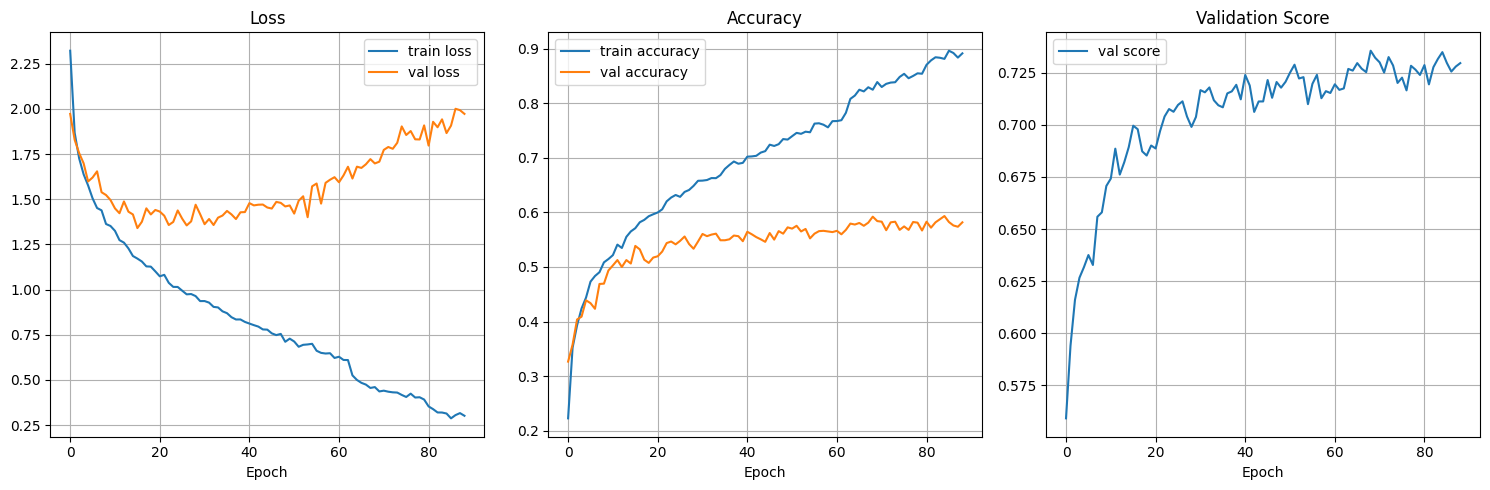

Training history saved to ./saved_models/fold_5_training_history.png
Test accuracy: 0.5923
Test score: 0.7355

Classification Report:
                                            precision    recall  f1-score   support

                  Forehead - pull hairline       0.54      0.47      0.50       136
                         Neck - pinch skin       0.40      0.40      0.40       136
                        Forehead - scratch       0.61      0.76      0.67       136
                       Eyelash - pull hair       0.43      0.54      0.48       136
                             Text on phone       0.87      0.96      0.92       136
                       Eyebrow - pull hair       0.31      0.32      0.31       136
                            Neck - scratch       0.43      0.45      0.44       136
                     Above ear - pull hair       0.53      0.36      0.43       136
                        Cheek - pinch skin       0.38      0.35      0.36       136
                         

{'n_folds': 5,
 'fold_results': [{'fold': 1,
   'model_path': './saved_models/fold_1_model.pth',
   'final_train_acc': 0.9063868337611355,
   'final_val_acc': 0.6308900523560209,
   'final_val_score': 0.7618665045296997,
   'test_accuracy': 0.6354712041884817,
   'test_score': 0.7692531759026534,
   'num_epochs': 100},
  {'fold': 2,
   'model_path': './saved_models/fold_2_model.pth',
   'final_train_acc': 0.833256634453137,
   'final_val_acc': 0.585171568627451,
   'final_val_score': 0.7332187730276735,
   'test_accuracy': 0.5931372549019608,
   'test_score': 0.7334917377166416,
   'num_epochs': 69},
  {'fold': 3,
   'model_path': './saved_models/fold_3_model.pth',
   'final_train_acc': 0.8530493410971499,
   'final_val_acc': 0.5747692307692308,
   'final_val_score': 0.7294364376073335,
   'test_accuracy': 0.5833846153846154,
   'test_score': 0.7381192320395651,
   'num_epochs': 70},
  {'fold': 4,
   'model_path': './saved_models/fold_4_model.pth',
   'final_train_acc': 0.8199110292989

In [28]:
run_kfold_training(agg_train_df, n_folds=5, num_epochs=100, batch_size=32, patience=20)

In [29]:
# =============================
# TEST DATA LOADING & PREPROCESSING
# =============================

# Load test data
test_df = pd.read_csv(f'{DATA_ROOT}/test.csv')
test_demo_df = pd.read_csv(f'{DATA_ROOT}/test_demographics.csv')
test_df = pd.merge(test_df, test_demo_df, how='left', on='subject')
print(f"Test data shape: {test_df.shape}")

# Apply feature engineering
test_df = feature_engineering(test_df)

# Apply feature scaling
test_df[NUMERICAL_FEATURES] = feature_scaler.transform(test_df[NUMERICAL_FEATURES])

# Aggregate sequences
agg_test_df = test_df.groupby(['sequence_id', 'subject']).apply(
    lambda df: df[FEATURE_NAMES].to_dict(orient='records'),
    include_groups=False,
).reset_index()
agg_test_df.columns = ['sequence_id', 'subject', 'sequence']
print(f"Aggregated test sequences: {len(agg_test_df)}")


Test data shape: (107, 343)
Aggregated test sequences: 2


In [30]:
# =============================
# TEST DATASET & DATALOADER
# =============================

class TestSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        self.processed_sequences = self._process_sequences()
        
    def _process_sequences(self):
        processed = []
        for seq in self.sequences:
            seq = seq[:MAX_SEQ_LENGTH]
            seq_array = []
            for timestep in seq:
                features = [timestep[feature] for feature in FEATURE_NAMES]
                seq_array.append(features)
            processed.append(np.array(seq_array, dtype=np.float32))
        return processed
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.FloatTensor(self.processed_sequences[idx])
        return sequence

def collate_fn_test(batch):
    sequences = batch
    max_length = max(seq.shape[0] for seq in sequences)
    
    padded_sequences = []
    lengths = []
    
    for seq in sequences:
        seq_len = seq.shape[0]
        lengths.append(seq_len)
        
        if seq_len < max_length:
            padding = torch.zeros(max_length - seq_len, seq.shape[1])
            padded_seq = torch.cat([seq, padding], dim=0)
        else:
            padded_seq = seq
        padded_sequences.append(padded_seq)
    
    return torch.stack(padded_sequences), torch.LongTensor(lengths)

# Create test loader
test_sequences = agg_test_df['sequence'].tolist()
test_dataset = TestSequenceDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_test)


In [34]:
# =============================
# MODEL LOADING & INFERENCE
# =============================

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
all_fold_preds = []
sequence_ids = agg_test_df['sequence_id'].tolist()

# Load each fold model and predict
for fold_num in range(1, 6):
    model_path = f'{OUTPUT_DIR}/fold_{fold_num}_model.pth'
    print(f"Loading model from {model_path}")
    
    # Create model architecture
    model = TwoBranchModel(
        imu_dim=len(FEATURE_NAMES),
        n_classes=len(LABEL_NAMES),
        weight_decay=3e-3
    )
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Make predictions
    fold_preds = []
    
    with torch.no_grad():
        for sequences, lengths in test_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            fold_preds.extend(preds.cpu().numpy())
    
    all_fold_preds.append(fold_preds)
    print(f"Fold {fold_num} predictions complete")


Loading model from ./saved_models/fold_1_model.pth
Fold 1 predictions complete
Loading model from ./saved_models/fold_2_model.pth
Fold 2 predictions complete
Loading model from ./saved_models/fold_3_model.pth
Fold 3 predictions complete
Loading model from ./saved_models/fold_4_model.pth
Fold 4 predictions complete
Loading model from ./saved_models/fold_5_model.pth
Fold 5 predictions complete


In [35]:
# =============================
# ENSEMBLE PREDICTIONS
# =============================

# Ensemble predictions (majority voting)
ensemble_preds = []
for i in range(len(test_sequences)):
    votes = [preds[i] for preds in all_fold_preds]
    majority_vote = np.bincount(votes).argmax()
    ensemble_preds.append(majority_vote)

# Map predictions to labels
predicted_labels = [LABEL_NAMES[pred] for pred in ensemble_preds]


In [37]:
# =============================
# SUBMISSION CREATION
# =============================

# Create submission DataFrame
submission_df = pd.DataFrame({
    'sequence_id': sequence_ids,
    'gesture': predicted_labels
})

# Save submission
submission_path = f'{OUTPUT_DIR}/submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")
print(f"Sample submission:\n{submission_df.head()}")


Submission saved to ./saved_models/submission.csv
Sample submission:
  sequence_id        gesture
0  SEQ_000001  Text on phone
1  SEQ_000011     Wave hello
